# 9.1 Generative Algorithms

#### Generative Adversarial Networks (GAN)
At first, let's recap what a GAN is and how its structure looks like. GANs consist of an overall structure composed of two neural networks, one called the generator and the other called the discriminator. 

The role of the generator is to estimate the probability distribution of the real samples in order to provide generated samples resembling real data. The discriminator, in turn, is trained to estimate the probability that a given sample came from the real data rather than being provided by the generator.

These structures are called generative adversarial networks because the generator and discriminator are trained to compete with each other: the generator tries to get better at fooling the discriminator, while the discriminator tries to get better at identifying generated samples.

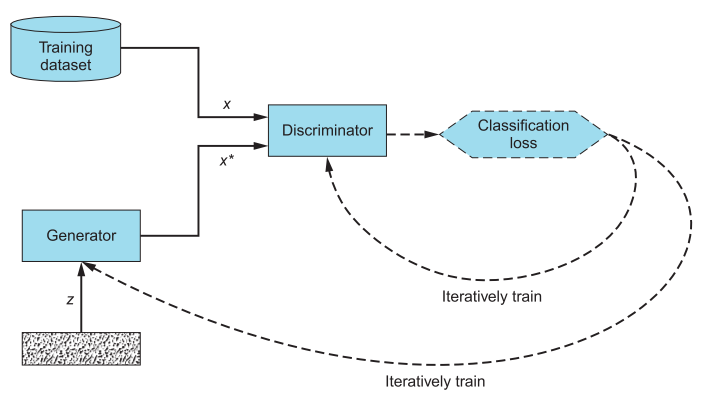

The Generator (G) takes in a random noise vector z and produces a fake example x*. Mathematically, G(z) = x*. The Discriminator (D) is presented either with a real example x or with a fake example x*; for each input, it outputs a value between 0 and 1 indicating the probability that the input is real.

Now let's take a look at the training algorithm:

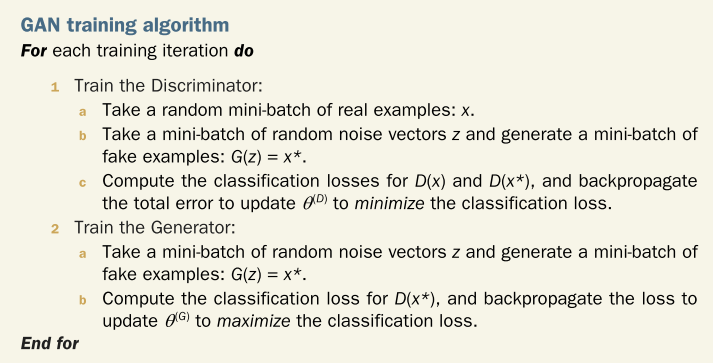

#### Your First GAN!
As a first example to better understand how GANs work you will create a GAN set up to generate the distribution of the sinus curve with a dataset composed of two-dimensional samples (x₁, x₂), with x₁ in the interval from 0 to 2π and x₂ = sin(x₁). For this example you will use the PyTorch library. Later you will also take a look at another machine learing library called keras, to generate handwritten digits.

## 1. Generate the Disribution of a Sinus Function with PyTorch

#### <u>Import libraries</u>

In [1]:
!pip install torch

In [2]:
import torch
from torch import nn  #Neural Networks

import math
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
#random generator seed so that the experiment can be replicated identically on any machine
torch.manual_seed(111)

#### <u>Preparing the Training Data</u>
The training data is composed of pairs (x₁, x₂) so that x₂ consists of the value of the sin of x₁ for x₁ in the interval from 0 to 2π.

In [6]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))

# x1 random numbers between 0 and 2pi 
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)     

# x2 values of sin(x1)                 
train_data[:, 1] = torch.sin(train_data[:, 0])

# labels are required by PyTorch's data loader, but will not be used as GANs make use of unsupervised learning techniques.                                      
train_labels = torch.zeros(train_data_length)

# combine to training set as expected by PyTorch's data loader
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]    

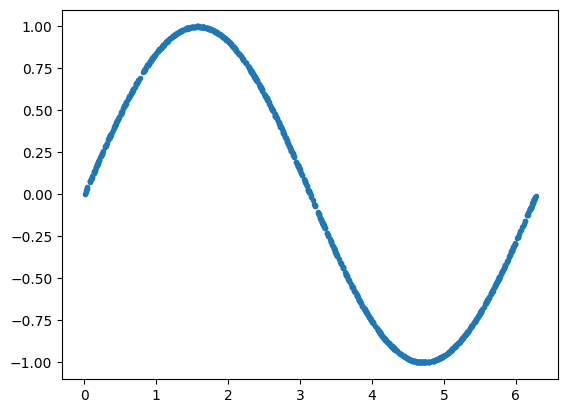

In [7]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")                   # Plot training data -> sin

#### <u>Create PyTorch data loader</u>
You create a [data loader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) called train_loader, which will shuffle the data from the train_set and return batches of 32 samples that you’ll use to train the neural networks.

In [8]:
### TASK: Create a pytorch data loader with the batch_size 32
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

#### <u>Implementing the Discriminator</u>
The discriminator is a model with a two-dimensional input and a one-dimensional output. It’ll receive a sample from the real data or from the generator and will provide the probability that the sample belongs to the real training data.

In [9]:
### TASK adapt the Discriminator and Generator class in order to create a functional Neural Network with the correct number of neurons

class Discriminator(nn.Module):                 # In PyTorch, the neural network models are represented by classes that inherit from nn.Module.
    def __init__(self):                         # build model
      
        super().__init__()                      
        self.model = nn.Sequential(
            # two-dimensional input with first hidden layer with 256 neurons
            nn.Linear(2, 256),
            # ReLU Activation function                     
            nn.ReLU(),
            # use dropout after hidden layers to avoid overfitting                          
            nn.Dropout(0.3), 
            # Hidden layer 1                   
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            # Hidden layer 2
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            # Sigmoid Activation function in range [0,1]
            nn.Sigmoid(),                       
        )

    # calculate output of the model with input x
    def forward(self, x):                       
        output = self.model(x)
        return output

# instantiate a Discriminator object
discriminator = Discriminator()                 

#### <u>Implementing the Generator</u>
In generative adversarial networks, the generator is the model that takes samples from a latent space as its input and generates data resembling the data in the training set. In this case, it’s a model with a two-dimensional input, which will receive random points (z₁, z₂), and a two-dimensional output that must provide (x̃₁, x̃₂) points resembling those from the training data.

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

### Training the Models

#### <U>Setting parameters</u>

In [11]:
# learning rate (lr), which you’ll use to adapt the network weights
lr = 0.001                          
# number of epochs (num_epochs), which defines how many repetitions of training using the whole training set will be performed
num_epochs = 300                    
# loss_function to the binary cross-entropy function BCELoss(), which is the loss function that you’ll use to train the models
loss_function = nn.BCELoss()        

The binary cross-entropy function is a suitable loss function for training the discriminator because it considers a binary classification task. It’s also suitable for training the generator since it feeds its output to the discriminator, which provides a binary observable output.

PyTorch implements various weight update rules for model training in torch.optim. Here we’ll use the Adam algorithm to train the discriminator and generator models:

In [12]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

#### <u>Training Loop</u>
For GANs, you update the parameters of the discriminator and the generator at each training iteration. As is generally done for all neural networks, the training process consists of two loops, one for the training epochs and the other for the batches for each epoch. We take a look at the results after a few epoches.

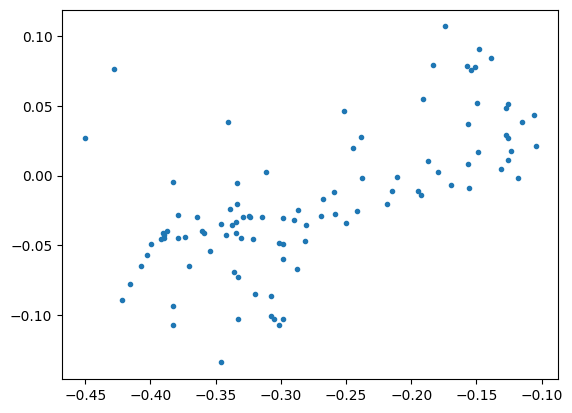

In [17]:
%matplotlib inline
from IPython.display import clear_output

def show_result():
    
    latent_space_samples = torch.randn(100, 2)
    ### TASK: create generated samples
    generated_samples = generator(latent_space_samples)
    generated_samples = generated_samples.detach()                      # use .detach() to return a tensor from the PyTorch computational graph, which you’ll then use to calculate the gradients
    
    ### TASK: plot samples
    plt.plot(generated_samples[:, 0], generated_samples[:,1], ".")    
    plt.show()
    
show_result()

In [18]:
gen_loss = []
dis_loss = []
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):                # get the real samples of the current batch from the data loader and assign them to real_samples
        
        # Data for training the discriminator
        
        ### TASK: create labels with the value 1 for the real samples for each batch (Hint: Use torch.ones)
        real_samples_labels = torch.ones((batch_size, 1))
        
        
        latent_space_samples = torch.randn((batch_size, 2))             # create the generated samples by storing random data in latent_space_samples,
        generated_samples = generator(latent_space_samples)             # then feeding it to the generator to obtain generated_samples
        
        ### TASK create labels with the value 0 for the fake samples for each batch (Hint: Use torch.zeros)
        generated_samples_labels = torch.zeros((batch_size,1))
        
        
        all_samples = torch.cat((real_samples, generated_samples))      
        all_samples_labels = torch.cat(                                 
            (real_samples_labels, generated_samples_labels)             # concatenate the real and generated samples and labels and store them in all_samples and all_samples_labels.
        )

        # Training the discriminator
        discriminator.zero_grad()                                       # In PyTorch, it’s necessary to clear the gradients at each training step to avoid accumulating them
        output_discriminator = discriminator(all_samples)               # calculate the output of the discriminator using the training data in all_samples
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)                   # calculate the loss function using the output from the model in output_discriminator and the labels in all_samples_labels
        loss_discriminator.backward()                                   # calculate the gradients to update the weights with loss_discriminator.backward()
        optimizer_discriminator.step()                                  # update the discriminator weights by calling optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))             # create random data to feed your generator

        # Training the generator
        generator.zero_grad()                                               # clear the gradients with .zero_grad()
        generated_samples = generator(latent_space_samples)                 # feed the generator with latent_space_samples 
        output_discriminator_generated = discriminator(generated_samples)   # feed the generator’s output into the discriminator
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels             # calculate the loss function using the output of the classification system stored in output_discriminator_generated
        )                                                                   # and the labels in real_samples_labels
        loss_generator.backward()                                           # calculate the gradients
        optimizer_generator.step()                                          # update the generator weights
                                                                            # the discriminator weights are frozen since you created optimizer_generator with its first argument equal to generator.parameters()
        dis_loss.append(loss_discriminator)
        gen_loss.append(loss_generator)
        # Show loss
        if epoch % 50 == 0 and n == batch_size - 1:
            clear_output(wait=True)
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            show_result()

ValueError: too many values to unpack (expected 2)

#### *Exercise - try it out!*
1. Set different hyperparameters for the training (learning rate, number of epoches, batch size) and analyse how the results are changing.
2. Try different topologies for the neural networks, e.g. change the number of nodes in hidden layers or even remove or add a hole hidden layer. Analyse again the influence on the results.